In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from energy_harvest import EnergyHarvester
from apply_policy import sparsify_data, classify_packets

from utils.setup_funcs import *
from datasets.dsads_contig.dsads import *
from models import *
from datasets.apply_policy import *

In [82]:
root_dir = os.path.join(PROJECT_ROOT,"../data/dsads/merged_preprocess")
train_data = np.load(f"{root_dir}/training_data.npy")
train_labels = np.load(f"{root_dir}/training_labels.npy")

val_data = np.load(f"{root_dir}/val_data.npy")
val_labels = np.load(f"{root_dir}/val_labels.npy")

test_data = np.load(f"{root_dir}/testing_data.npy")
test_labels = np.load(f"{root_dir}/testing_labels.npy")

# preprocess
mean = torch.tensor(np.mean(train_data,axis=0))
std = torch.tensor(np.std(train_data,axis=0))
# cannot apply here because need units of m/s^2 for harvesting
# train_data = (train_data-mean)/(std + 1e-5)
# val_data = (val_data-mean)/(std + 1e-5)
# test_data = (test_data-mean)/(std + 1e-5)

# load pretrained classifier
model = SimpleNet(3,19)
ckpt_path = os.path.join(PROJECT_ROOT,f"saved_data/checkpoints/dsads_contig/seed{123}.pth")
model.load_state_dict(torch.load(ckpt_path)['model_state_dict'])


<All keys matched successfully>

In [83]:
FS = 25 # sampling frequency
PACKET_SIZE = 8
LEAKAGE = 6e-6
INIT_OVERHEAD = 150e-6
s = 10000
e = 12000
val_data = val_data[s:e,:]
val_labels = val_labels[s:e]

In [84]:
eh = EnergyHarvester()
	
# add time axis
t_axis = np.arange(len(val_labels))/FS
t_axis = np.expand_dims(t_axis,axis=0).T

# add the time axis to the data
full_data_window = np.concatenate([t_axis,val_data],axis=1)

opp_packets, opp_e_trace = sparsify_data(full_data_window,PACKET_SIZE,LEAKAGE,INIT_OVERHEAD,eh,'opportunistic',train_mode=False)
	

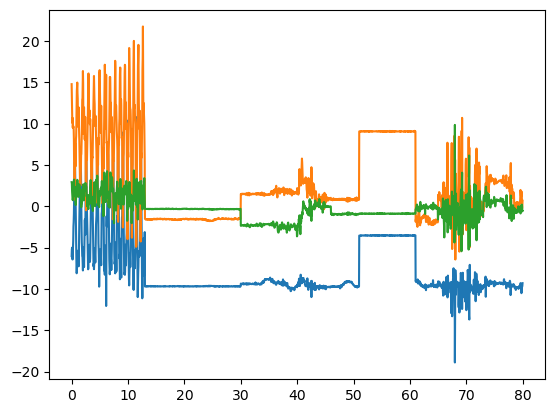

In [85]:
plt.plot(full_data_window[:,0],full_data_window[:,1])
plt.plot(full_data_window[:,0],full_data_window[:,2])
plt.plot(full_data_window[:,0],full_data_window[:,3])

In [86]:
opp_packets

(array([12.4]),
 array([[[-4.2134 ,  8.2693 ,  1.6143 ],
         [-1.0187 ,  2.5113 ,  0.55933],
         [ 5.0687 , -3.2462 ,  0.32776],
         [ 8.5639 , -4.2625 ,  0.96932],
         [ 9.6758 , -1.9842 ,  2.4298 ],
         [ 5.7721 ,  2.0328 ,  3.0673 ],
         [ 0.64924,  6.4252 ,  0.60359],
         [-1.8707 ,  5.8791 ,  1.4689 ]]]))

In [87]:
dense_outputs, dense_preds, dense_targets, dense_outputs_opp, dense_preds_opp, dense_targets_policy = classify_packets(val_data,val_labels,opp_packets,model,PACKET_SIZE, mean, std)

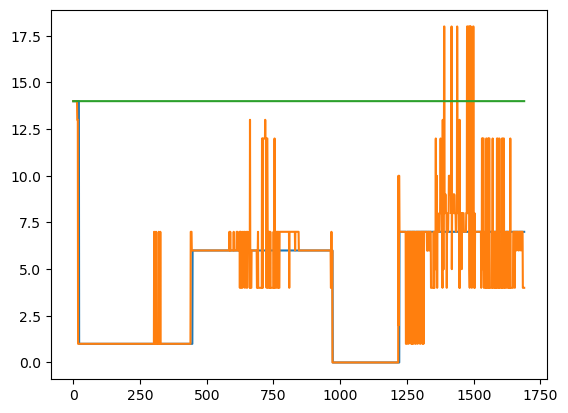

In [88]:
plt.plot(dense_targets)
plt.plot(dense_preds)
plt.plot(dense_preds_opp)

In [89]:
print((dense_targets==dense_preds).float().mean())
print((dense_targets==dense_preds_opp).float().mean())

tensor(0.7095)
tensor(0.0130)


In [90]:
from sklearn.metrics import f1_score

In [91]:
print(f1_score(dense_targets, dense_preds_opp,average='macro'))
print(f1_score(dense_targets, dense_preds,average='macro'))

0.0051401869158878505
0.2872561042685224


In [94]:
(dense_preds[0]==dense_targets[0]).float()

tensor(1.)